# NN (L) Global Sustainable Equity time series forecasting using Prophet

## Start timing the analysis

In [1]:
import timeit
start_time = timeit.default_timer()

## Import all the necessary libraries

In [2]:
# Import all the necessary libraries
import time
import os
import datetime as dt
import pandas as pd
import io
import matplotlib.pyplot as plt

from fbprophet import Prophet
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
from dask.distributed import Client # import Dask for parallelising cross validation

## Import, clean and visualise the historical data

The historical chart didn't exist and it has been created.


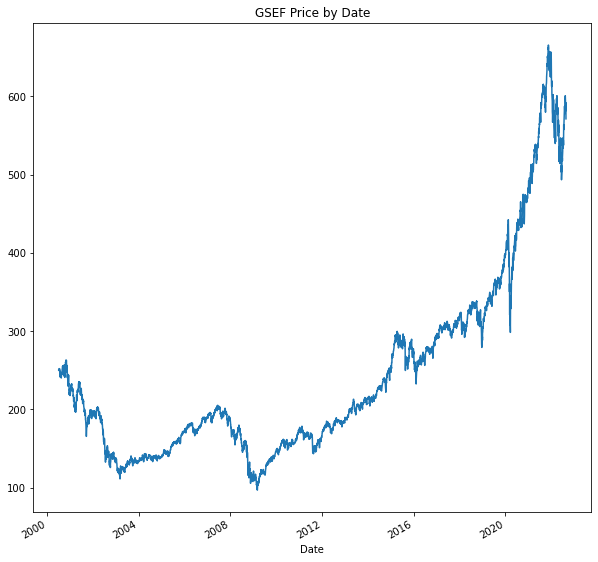

In [3]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_column',None)
tomorrow = (dt.date.today() + dt.timedelta(days=1)).isoformat() #get tomorrow in iso format as needed'''
url = pd.read_html("https://markets.ft.com/data/funds/tearsheet/historical?s=LU0119216553:EUR", header=0)
table = url[0]
gsef_latest = table[['Date', 'Close']]
gsef_latest_selected= gsef_latest.copy()

gsef_latest_selected['Date'] = gsef_latest_selected.loc[:,'Date'].str[-12:]
gsef_latest_selected['Date'] = pd.to_datetime(gsef_latest_selected['Date'], dayfirst=True)

gsef_historical= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

gsef = pd.concat([gsef_latest_selected, gsef_historical], ignore_index=True).sort_values(by="Date")

gsef = gsef.reset_index(drop=True)

gsef['pct_change']= (gsef["Close"].pct_change()*100).round(2)

gsef = gsef.drop_duplicates('Date')

gsef.to_csv('gsef_output/historical_gsef.csv', index=False)

gsef.plot(x= 'Date', y='Close', figsize=(10,10), title= 'GSEF Price by Date', legend=False)

historical_chart= 'gsef_output/gsef_historical.png'

# Check if the historical data's chart exists and save its latest version
if os.path.exists(historical_chart):
  os.remove(historical_chart)
else:
  print("The historical chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_historical.png')

plt.show()

In [4]:
# Brief Description of our dataset
gsef.describe()

Close   pct_change
count  5586.000000  5585.000000
mean    241.608545     0.020836
std     120.485423     1.086879
min      96.810000    -9.930000
25%     157.595000    -0.480000
50%     195.985000     0.070000
75%     294.115000     0.560000
max     665.450000     9.540000

In [5]:
gsef.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5586 entries, 0 to 5604
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5586 non-null   datetime64[ns]
 1   Close       5586 non-null   float64       
 2   pct_change  5585 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 174.6 KB


In [6]:
gsef.tail()

Date   Close  pct_change
5596 2022-08-22  584.14       -1.34
5598 2022-08-23  581.30       -0.49
5600 2022-08-24  583.97        0.46
5602 2022-08-25  591.76        1.33
5604 2022-08-26  571.15       -3.48

In [7]:
# Drop the columns
gsef = gsef.drop('pct_change', axis=1)
gsef.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

gsef.tail()

ds       y
5596 2022-08-22  584.14
5598 2022-08-23  581.30
5600 2022-08-24  583.97
5602 2022-08-25  591.76
5604 2022-08-26  571.15

## Hyperparameter tuning

In [8]:
client = Client()  # connect to the cluster

# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'daily_seasonality': [False]
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(gsef)  # Fit model with given params
#     df_cv = cross_validation(m, horizon='30 days', parallel="dask")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [9]:
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

In [10]:
# changepoint_prior_scale= best_params['changepoint_prior_scale'] # last selected changepoint_prior_scale= 0.5
# seasonality_prior_scale= best_params['seasonality_prior_scale'] # last selected seasonality_prior_scale= 0.01

## Initiating and training the Prophet algorithm

Steps for using Prophet:
- Make sure you replace closing price for y and date for ds.
- Fit that dataframe to Prophet in order to detect future patterns.
- Predict the upper and lower prices of the closing price.

In [11]:
#m = Prophet(daily_seasonality=False, changepoint_prior_scale= changepoint_prior_scale, seasonality_prior_scale= seasonality_prior_scale)

m = Prophet(daily_seasonality=False, weekly_seasonality=False)

m.fit(gsef)

In [12]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
5946 2023-08-22  684.072663  650.867093  714.886055
5947 2023-08-23  684.334657  650.437985  716.367177
5948 2023-08-24  684.601329  650.194964  714.493120
5949 2023-08-25  684.871536  648.566733  718.044297
5950 2023-08-26  685.144015  650.276243  717.161720

You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

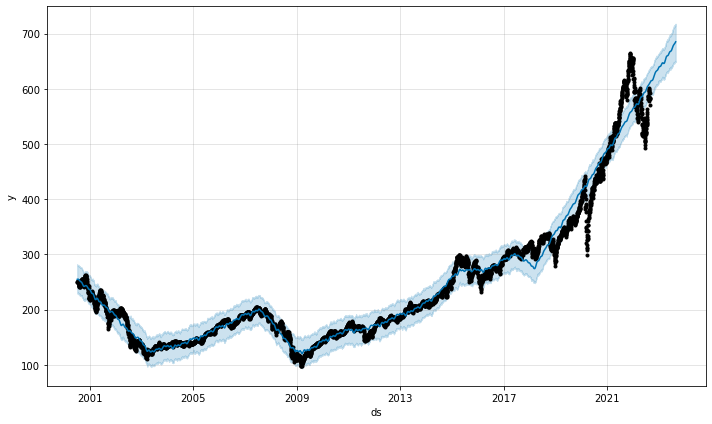

In [13]:
fig1 = m.plot(forecast)

## Plot the trend and the yearly seasonality

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

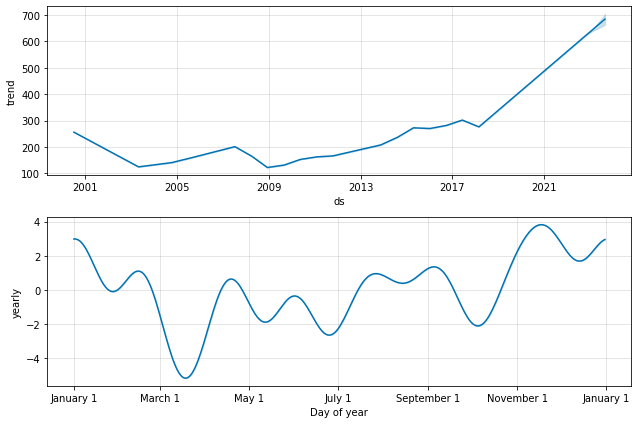

In [14]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

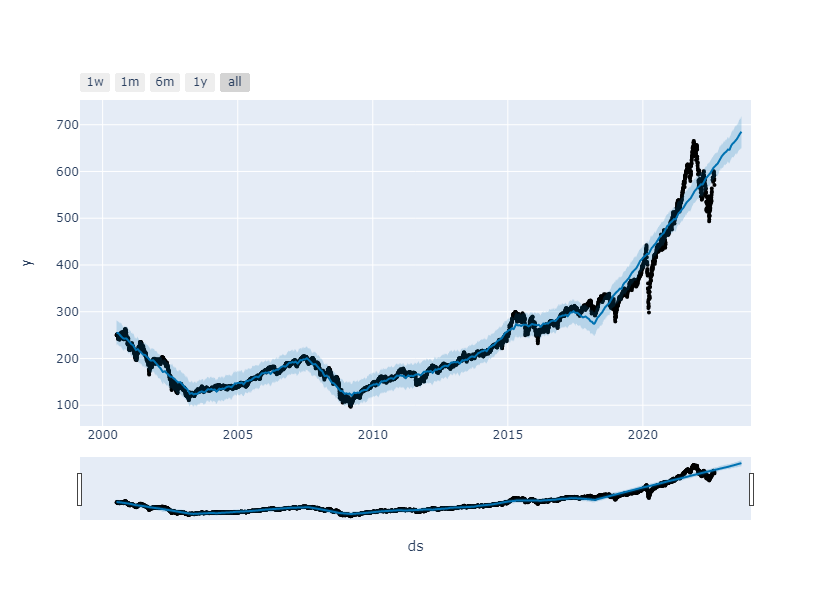

In [15]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

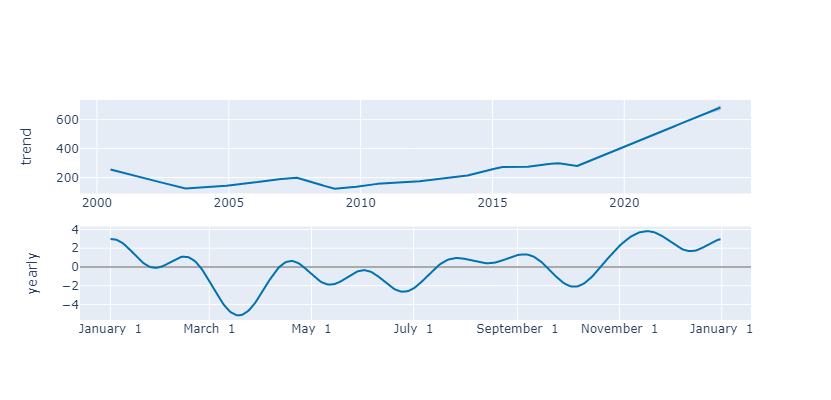

In [16]:
plot_components_plotly(m, forecast)

## Parallelized Cross validation

In [17]:
df_cv = cross_validation(m, horizon='30 days', parallel="dask")

INFO:prophet:Making 513 forecasts with cutoffs between 2001-07-17 00:00:00 and 2022-07-27 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:57031' processes=4 threads=8, memory=15.39 GiB>


In [18]:
df_cv.tail()

ds        yhat  yhat_lower  yhat_upper       y     cutoff
10617 2022-08-22  610.483746  584.803147  635.767198  584.14 2022-07-27
10618 2022-08-23  610.693053  585.037288  636.239661  581.30 2022-07-27
10619 2022-08-24  610.903525  585.815553  637.552286  583.97 2022-07-27
10620 2022-08-25  611.114741  585.648026  635.307354  591.76 2022-07-27
10621 2022-08-26  611.326183  586.292211  639.624777  571.15 2022-07-27

In [19]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon         mse       rmse        mae      mape     mdape     smape  \
0  3 days  675.650970  25.993287  15.883009  0.061283  0.042256  0.062612   
1  4 days  688.771499  26.244457  16.122303  0.062251  0.041707  0.063625   
2  5 days  702.843124  26.511189  16.400587  0.063298  0.042152  0.064672   
3  6 days  681.404944  26.103734  16.318760  0.063866  0.041362  0.065212   
4  7 days  671.909033  25.921208  16.333077  0.064583  0.042081  0.065989   

   coverage  
0  0.497175  
1  0.502342  
2  0.504241  
3  0.507009  
4  0.501021

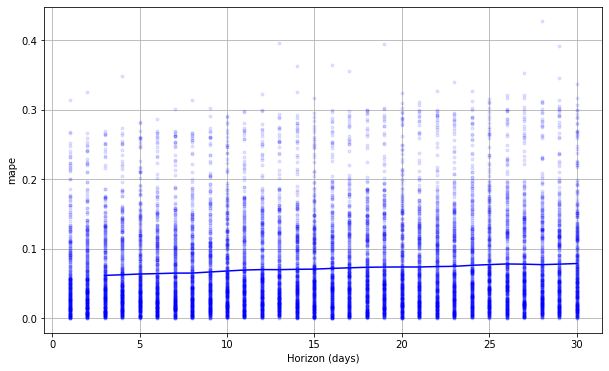

In [20]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Calculate the analysis' and forecast's timing

In [21]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_minutes = int((time_elapsed % 3600) // 60)

time_elapsed_seconds = int(time_elapsed % 60)

now = dt.datetime.now()

print("\n Success! Your GSEF forecast using Prophet has been updated in {} minutes and {} seconds on {}".format(time_elapsed_minutes, time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF forecast using Prophet has been updated in 14 minutes and 59 seconds on 2022-08-29 18:50:39


## Possible improvements of this analysis

1) Can more hyperparameter tuning be implemented to significantly improve accuracy?
2) If necessary, re-order the analysis in the notebook and automate the analysis wherever possible
3) Remove any unnecessary or steps that don't add value from the analysis 
4) Document the notebook 
5) Create a .py script of the notebook 